<a href="https://colab.research.google.com/github/nyla-bhargava/Brain_Tumour_Detection/blob/main/Brain_Tumor_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install split-folders

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import os
import torch
from PIL import Image
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torchvision import utils
from torchvision.datasets import ImageFolder
import splitfolders
import torch.nn.functional as F
import pathlib
from torch import optim

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.listdir("/content/drive/MyDrive/Brain Tumor Data Set/Brain Tumor Data Set")

In [10]:
data_dir = "/content/drive/MyDrive/Brain Tumor Data Set"
data_dir = pathlib.Path(data_dir)

splitfolders.ratio(data_dir, output='brain', seed=41, ratio=(0.8, 0.2))

Copying files: 2916 files [00:51, 56.37 files/s] 


In [11]:
data_dir = "/content/brain"
data_dir = pathlib.Path(data_dir)

In [12]:
transform = transforms.Compose(
    [
        transforms.Resize((128,128)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

In [13]:
train_set = torchvision.datasets.ImageFolder(data_dir.joinpath('train'), transform=transform)
train_set.transform
val_set = torchvision.datasets.ImageFolder(data_dir.joinpath('val'), transform=transform)
val_set.transform

Compose(
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [14]:
print(train_set)

Dataset ImageFolder
    Number of datapoints: 2332
    Root location: /content/brain/train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


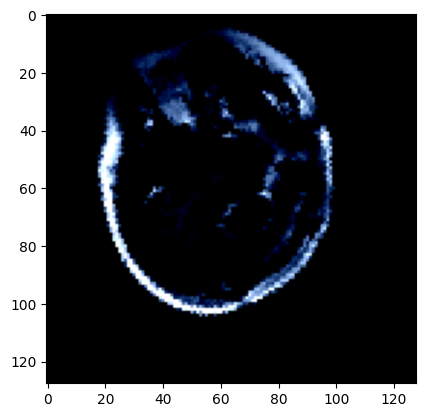

In [15]:
img, label = train_set[1000]
plt.imshow(img.permute(1,2,0))

In [16]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [17]:
next(iter(val_loader))[0].shape

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


torch.Size([64, 3, 128, 128])

In [18]:
class CNNModel(nn.Module):
  def __init__(self):
    super(CNNModel, self).__init__()

    #Conv 1
    self.cnv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0) #128-5+1=124

    #Max Pool 1
    self.maxpool1 = nn.MaxPool2d(kernel_size=2) #124/2 = 64

    #Conv 2
    self.cnv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0) #60

    #Max Pool 2
    self.maxpool2 = nn.MaxPool2d(kernel_size=2) #30

    #Conv 3
    self.cnv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=0) #26

    #Max Pool 3
    self.maxpool3 = nn.MaxPool2d(kernel_size=2) #13

    #Conv 4
    self.cnv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=0) #9

    #Max Pool 4
    self.maxpool4 = nn.MaxPool2d(kernel_size=2) #4

    #Activation Function
    self.leakyRelu = nn.LeakyReLU()

    #Fully connected Layer 1
    self.fc1 = nn.Linear(128*4*4, 1024)

    #Fully connected Layer 2
    self.fc2 = nn.Linear(1024, 2)

  def forward(self, x):
    #Layer 1
    out = self.leakyRelu(self.cnv1(x))
    out = self.maxpool1(out)

    #Layer 2
    out = self.leakyRelu(self.cnv2(out))
    out = self.maxpool2(out)

    #Layer 3
    out = self.leakyRelu(self.cnv3(out))
    out = self.maxpool3(out)

    #Layer 4
    out = self.leakyRelu(self.cnv4(out))
    out = self.maxpool4(out)

    #flatten
    out = out.view(out.size(0), -1)

    # Linear Function
    out = self.leakyRelu(self.fc1(out))
    out = self.fc2(out)

    return out



In [19]:
# Training CNN
num_epochs = 10
model = CNNModel()
error = nn.CrossEntropyLoss()

lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

In [20]:
train_loss_list = []
val_loss_list = []
accuracy_list = []

for epoch in range(num_epochs):
  train_loss = 0
  val_loss = 0
  for i, (images, labels) in enumerate(train_loader):

    optimizer.zero_grad()
    outputs = model(images)
    loss = error(outputs, labels)
    train_loss+=loss.item()
    loss.backward()
    optimizer.step()
    print("Loss in Iteration:", i, ":", loss.item())
  total = 0
  correct = 0
  for images, labels in val_loader:
    outputs = model(images)
    v_loss = error(outputs, labels)
    val_loss+=v_loss.item()
    predicted = torch.max(outputs.data, 1)[1]

    total+=len(labels)
    correct+=(predicted==labels).sum()


  scheduler.step(val_loss/len(val_loader))
  accuracy = 100*correct/float(total)
  train_loss_list.append(train_loss/len(train_loader))
  val_loss_list.append(val_loss/len(val_loader))
  accuracy_list.append(accuracy)
  print("Epoch:{}  Loss:{}  Acciracy:{}%".format(epoch, train_loss/len(train_loader), accuracy))

Loss in Iteration: 0 : 0.6880369186401367
Loss in Iteration: 1 : 0.9929111003875732
Loss in Iteration: 2 : 0.6692939400672913
Loss in Iteration: 3 : 0.6863425970077515
Loss in Iteration: 4 : 0.6477529406547546
Loss in Iteration: 5 : 0.5627974271774292
Loss in Iteration: 6 : 0.41624823212623596
Loss in Iteration: 7 : 0.650631308555603
Loss in Iteration: 8 : 0.5230921506881714
Loss in Iteration: 9 : 0.40766310691833496
Loss in Iteration: 10 : 0.4462169110774994
Loss in Iteration: 11 : 0.2575986981391907
Loss in Iteration: 12 : 0.3376964330673218
Loss in Iteration: 13 : 0.4207229018211365
Loss in Iteration: 14 : 0.30913516879081726
Loss in Iteration: 15 : 0.4454597234725952
Loss in Iteration: 16 : 0.4197213053703308
Loss in Iteration: 17 : 0.28096702694892883
Loss in Iteration: 18 : 0.35248398780822754
Loss in Iteration: 19 : 0.3734268546104431
Loss in Iteration: 20 : 0.2872155010700226
Loss in Iteration: 21 : 0.34899377822875977
Loss in Iteration: 22 : 0.3253496289253235
Loss in Iteratio

In [21]:
train_loss_list

[0.4165113745508967,
 0.2964277203018601,
 0.2212997868254378,
 0.18085917186092687,
 0.12808013375143748,
 0.10567113329228517,
 0.08511293742402985,
 0.07451284105411253,
 0.09765487589646836,
 0.0762674724179748]

In [22]:
val_loss_list

[0.2893614634871483,
 0.2487919494509697,
 0.1678665667772293,
 0.23335190080106258,
 0.08731545340269804,
 0.11590317375957966,
 0.05570202795788646,
 0.07164558582007885,
 0.1256018362939358,
 0.07595465471968055]

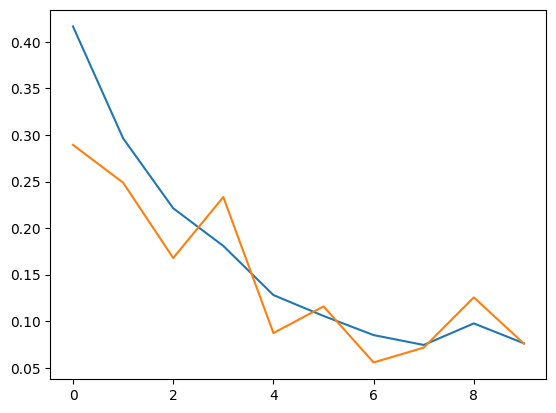

In [23]:
plt.plot(range(num_epochs), train_loss_list)
plt.plot(range(num_epochs), val_loss_list)

In [24]:
accuracy_list

[tensor(87.8425),
 tensor(91.7808),
 tensor(94.0069),
 tensor(90.0685),
 tensor(96.4041),
 tensor(95.2055),
 tensor(98.4589),
 tensor(96.7466),
 tensor(94.8630),
 tensor(97.0890)]

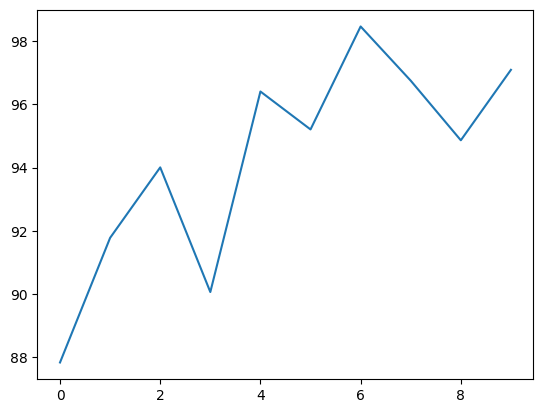

In [25]:
plt.plot(range(num_epochs), accuracy_list)

Text(0.5, 1.0, '1')

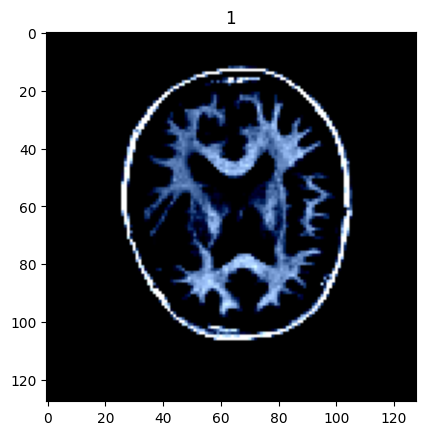

In [26]:
img, label = val_set[500]
plt.imshow(img.permute(1,2,0))
plt.title(label)

In [27]:
image = img.unsqueeze(0)

with torch.no_grad():
  output = model(image)

_, pred = torch.max(output, 1)
print("Predicted Output:", pred.item())

Predicted Output: 1
